# Solution 3

## FINM 37500 - 2023

### UChicago Financial Mathematics

* Mark Hendricks
* hendricks@uchicago.edu

# 1. Treasury Futures and Cheapest-to-Deliver

The file `data/fut_bond_data_FVU3_2023-04-21.xlsx` has market data on the following:
* 5-year Treasury future, expiring September 2023
* The specifications of the deliverable treasury bonds

Market quotes are provided on the futures contract and the bond prices. These will be useful for some of the analysis questions, but you do not need them for your models as you are provided a BDT tree which is fit to swaps and caps. See below for more details on this BDT model.

Suppose the present date is `2023-04-21`.

### BDT Model

In this problem you will make use of a BDT modeled binomial tree.

To save you some time, you are provided the parameters of a BDT tree fit to both swaps and caps.
* Use the file `bdt_params_freq52_2023-04-21.xlsx`
* With these $\sigma$ and $\theta$ parameters, you should be able to build a BDT tree with $T=5$ and $dt=1/52$.

#### Note
If interested in how this was done, find the data and files used to get these parameters. In particular, 
* The market quotes interpolated to weekly frequency: `cap_curves_2023-04-21_freq_52.xlsx`.
* The file to estimate the model is `Parameterize BDT.ipynb`.

## 1.1 Trading Bonds

Give brief answers to these based on the market quotes provided,
### 1.1.1
Calculate the 
* gross basis
* carry
* net basis for each bond

### 1.1.2
Which bond seems most likely to be CTD?

### 1.1.3
If you were required to put on a position today
* long one of the bonds
* short the future

which would you choose based on the data provided in the spreadsheet?

## 1.2 Conversion Factors

Calculate the conversion factor for each bond. Report it to `6` decimal places.

Do they match the conversion factor provided by Bloomberg?

## 1.3 BDT Tree

Report the number of steps for
* each bond's maturity
* the futures contract expiration

Build the interest-rate tree and display it.

## 1.4 Bond Pricing

Use the tree to price each bond. Report
* time-0 dirty and clean price of each bond
* terminal (clean) value of each bond at futures expiration, for each state of the tree.

Thus, to report the terminal values you will need to grab the expiration column of each bond's (clean) pricing tree and adjust (inflate) it for the conversion factor.

## 1.5 CTD

Use your terminal values calculated above to state which bond is CTD in each interest-rate state (at this expiration node.) 

Report the duration of each bond (as of today's price, not recomputed for the interest-rate nodes.) Do you see a relationship between the time-0 duration and the at-expiration CTD?

## 1.6 Futures Price

Model the futures price with the tree approach.
* Use the CTD terminal value for each rate.
* Step backward through the tree.

As you step backward remember that for a futures contract
* no discounting by the riskfree rate
* the futures contract has no capital requirement and thus an expected P&L of zero under this measure.

Thus, each node is the simple average of the two nodes at the following step.

**Report the futures price.**

### Compare
How does it compare to 
* the quoted futures price
* the modeled bond prices

## 1.7 Early Delivery
**Optional**
Above we modeled the terminal value at the futures expiration. Now consider if early delivery would be better.

Which periods in the tree are eligible to deliver based on the parameters of the 5-year futures contract? 

Based on your model, does it make sense to deliver early in any of the nodes of the tree?

## 1.8 Option-Adjusted Spread
**Optional**

Calculate and report the option-adjusted spread (OAS) for the future.

Note that you
* do NOT need to recalculate the bond prices
* will simply add a constant rate (at every node) for discounting the futures price in the previous problem.

What does the OAS indicate?

# **<span style="color:red">Solution 1</span>**

In [1]:
import numpy as np
import pandas as pd

from datetime import date
from datetime import datetime

import sys
sys.path.insert(0, '../cmds')
from ficcvol import *
from binomial import *
from ratecurves import *

In [2]:
import datetime
import warnings

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.rcParams['figure.figsize'] = (12,6)
plt.rcParams['font.size'] = 15
plt.rcParams['legend.fontsize'] = 13

import matplotlib.ticker as mtick
from matplotlib.ticker import (MultipleLocator,
                               FormatStrFormatter,
                               AutoMinorLocator)

#### Notation Commands

$$\newcommand{\cpn}{\text{c}}$$
$$\newcommand{\Tunder}{T_\text{bond}}$$
$$\newcommand{\accint}{\xi}$$
$$\newcommand{\convert}{\psi}$$
$$\newcommand{\ctd}{\text{ctd}}$$

$$\newcommand{\refrate}{r^{\text{ref}}}$$
$$\newcommand{\pfwd}{P_{\text{fwd}}}$$
$$\newcommand{\grossbasis}{\Gamma}$$
$$\newcommand{\netbasis}{\tilde{\grossbasis}}$$
$$\newcommand{\pnl}{\Pi}$$

$$\newcommand{\years}{\tau}$$
$$\newcommand{\yearsACT}{\years_{\text{act/360}}}$$

$$\newcommand{\fwdprice}{\mathcal{F}_{t\to T}}$$
$$\newcommand{\futprice}{F_{t\to T}}$$

$$\newcommand{\fwdpriceT}{\mathcal{F}_{T\to T}}$$
$$\newcommand{\futpriceT}{F_{T\to T}}$$

$$\newcommand{\fwdpriceDT}{\mathcal{F}_{t+h\to T}}$$
$$\newcommand{\futpriceDT}{F_{t+h\to T}}$$

$$\newcommand{\rrepo}{r^{\text{repo}}}$$
$$\newcommand{\carry}{\widetilde{\cpn}}$$

## Parameters

In [3]:
DATE = '2023-04-21'
FREQ = 52
futtick = 'FVU3'

FACE = 100

## Load Market Data

In [4]:
futdata = pd.read_excel(f'../data/fut_bond_data_{futtick}_{DATE}.xlsx', sheet_name=f'future').set_index('field').iloc[:,0]
futdata

field
last_update_dt         2023-04-21 00:00:00
px_last                         109.789062
last_tradeable_dt      2023-09-29 00:00:00
fut_dlv_dt_last        2023-10-04 00:00:00
fut_days_expire                        159
fut_ctd                   T 3.875 11/30/27
fut_ctd_px                      100.757812
fut_ctd_gross_basis             -17.074348
fut_ctd_net_basis                 1.199828
Name: FVU3 Comdty, dtype: object

In [5]:
bonddata = pd.read_excel(f'../data/fut_bond_data_{futtick}_{DATE}.xlsx', sheet_name=f'bonds').set_index('ticker')
bonddata

,last_update_dt,px_last,maturity,days_to_mty,cpn,nxt_cpn_dt,days_to_next_coupon,int_acc,accrued_days_between_cpn_dates,days_acc,basis_mid,repo_implied_reporate,repo_reporate,conversion
ticker,,,,,,,,,,,,,,
91282CFZ Govt,2023-04-21,100.757812,2027-11-30,1681,3.875,2023-05-31,37,1.543613,182,145,13.138350,3.619994,4.815,0.9226
91282CGC Govt,2023-04-21,100.750000,2027-12-31,1712,3.875,2023-06-30,67,1.220304,181,114,17.307175,3.644369,4.815,0.9212
91282CGH Govt,2023-04-21,99.195312,2028-01-31,1743,3.500,2023-07-31,98,0.802486,181,83,24.180222,3.631045,4.815,0.9058
91282CGP Govt,2023-04-21,101.484375,2028-02-29,1772,4.000,2023-08-31,129,0.597826,184,55,32.893100,3.550495,4.815,0.9234
91282CGT Govt,2023-04-21,99.828125,2028-03-31,1803,3.625,2023-09-30,159,0.237705,183,24,38.039247,3.570506,4.815,0.9075


## <span style="color:red">1.1 Basis</span>

### Calculate Gross Basis

$$\text{gross basis} \equiv \grossbasis^i_{t,T} = P_t^i - \futprice\convert^i$$

In [6]:
px = bonddata['px_last']

gross_basis = (px - futdata.loc['px_last'] * bonddata['conversion']).to_frame().rename(columns={0:'dollars'})
gross_basis['32nds'] = gross_basis * 32
gross_basis.columns.name = 'gross basis'
gross_basis

gross basis,dollars,32nds
ticker,,
91282CFZ Govt,-0.533577,-17.074450
91282CGC Govt,-0.387684,-12.405900
91282CGH Govt,-0.251620,-8.051850
91282CGP Govt,0.105155,3.364950
91282CGT Govt,0.194551,6.225625


#### Confirm Bloomberg

Note that the provided futures data gives Bloomberg's calculation of which bond is CTD and its associated gross basis.

Our calculation of gross basis matches (quoted in 32nds).

### Calculate Net Basis

#### Caution
Bloomberg's calculation is a bit different than the standard definition.
* Don't worry about whether our (standard) definition and calculation matches their reported net basis for the CTD.
* Part of this difference (but not all of it) is that Bloomberg assumes it takes a few days to settle. (If you use a delay of one day, the forward price will properly match.)
* The parameter `days_settle` below allows for this to vary, but it makes very little difference whether it is set to $\pm$ 0,1,2.

In [7]:
days_settle = 0

### Calculate Net Basis as Gross Basis Minus Carry

$$\begin{align*}
\text{net basis} \equiv \netbasis^i_{t,T} =& \grossbasis^i_{t,T} - \left(\cpn N - \rrepo P_t^{i,\text{dirty}}\right)\yearsACT\\
=& \grossbasis^i_{t,T} - \left[\cpn N - \rrepo \left(P_t^{i} + \accint_t^i\right)\right]\yearsACT
\end{align*}$$

recalling that
* $N$ denotes the notional, (here face value of 100)
* $\accint$ denotes accrued interest
* $\rrepo$ denotes the repo rate
* $\yearsACT$ denotes the time interval quoted as ACT/360

In [8]:
cpn = bonddata['cpn']/100
repo = bonddata['repo_reporate']/100

days_fwd = futdata.loc['fut_days_expire'] - days_settle
days_cpn_period = bonddata['accrued_days_between_cpn_dates']
days_already_accrued = bonddata['days_acc'] + days_settle

int_already_acc = cpn*FACE/2 * (days_already_accrued / days_cpn_period)
pxdirty = px + int_already_acc

carry = ((FACE * cpn - repo * pxdirty) * days_fwd / 360).to_frame().rename(columns={0:'dollars'})
carry['32nds'] = carry * 32
net_basis = gross_basis - carry
net_basis.columns.name = 'net basis'
net_basis

net basis,dollars,32nds
ticker,,
91282CFZ Govt,-0.069467,-2.222951
91282CGC Govt,0.069383,2.220265
91282CGH Govt,0.329125,10.531985
91282CGP Govt,0.509394,16.300596
91282CGT Govt,0.721534,23.089090


#### Confirm

CTD
* The bond with the smallest net basis is seen by the market as being most likely to be CTD.
* The corresponding bond indeed matches what Bloomberg's future data reported as the CTD bond.

Negative net basis
* The net basis is negative, which would suggest an arbitrage is possible.
* Due to market frictions, we shouldn't be surprised to see this slight negative value.
* Trading on it would require us to short the future and go long the bond. There will be some cost of capital in the position.

### Calculate net basis using forward price 

Net basis is also calculated with the same formula as gross basis, but replacing the spot price with the forward price:

$$\text{net basis} \equiv \netbasis^i_{t,T} = \fwdprice^i - \futprice\convert^i$$

recalling that
* $\fwdprice$ denotes the forward price
* $\futprice$ denotes the futures price
* $\convert$ denotes the bond's conversion factor

As we saw in Week 2, no-arbitrage (and frictionless markets) would imply the forward price is exactly the spot price minus carry, in which case this definition would match.

### Forward Price

The forward price is given by the no-arbitrage relationship:

$$\begin{align*}
\text{dirty} \fwdprice =& (P_t^i + \accint_t^i)\left(1+\rrepo_t\, \yearsACT\right)\\
\fwdprice =& (P_t^i + \accint^i_t)\left(1+\rrepo_t\, \yearsACT\right) - \accint_T
\end{align*}$$


#### With interim coupons
If there are interim coupons, the no-arbitrage relationship still holds,
* buy the bond at the dirty price
* simultaneously repo it
* when the coupon pays, use it to reduce the repo balance
* finally, at the terminal date, close out the repo

$$\begin{align*}
\text{dirty} \fwdprice =& \left[(P_t^i + \accint_t)\left(1+\rrepo_t\, \tau_0\right)-100\frac{\cpn}{2}\right]\left(1+\rrepo_t\, \tau_1\right)\\
\fwdprice =& \left[(P^i_t + \accint^i_t)\left(1+\rrepo_t\, \tau_0\right)-100\frac{\cpn}{2}\right]\left(1+\rrepo_t\, \tau_1\right) - \accint^i_T
\end{align*}$$
where
* $\tau_0$ denotes the pre-coupon forward interval, $t_{\text{coupon}}-t$ denoted as ACT/360
* $\tau_1$ denotes the pre-coupon forward interval, $T-t_{\text{coupon}}$ denoted as ACT/360
* note that $\tau=\tau_0+\tau_1$, so the formula is simply splitting the forward interval into pre and post-coupon intervals.

In [9]:
days_next_cpn_period = 365-days_cpn_period
days_next_cpn = bonddata['days_to_next_coupon'] - days_settle
days_past_cpn = (days_fwd - days_next_cpn)
days_terminal_accrued = days_already_accrued + days_fwd

int_postcpn_acc = cpn*FACE/2 * (days_past_cpn / days_next_cpn_period)

fwd_prices = ((px + int_already_acc)  * (1+repo * days_next_cpn/360) - FACE*cpn/2) * (1+repo * days_past_cpn/360) - int_postcpn_acc
fwd_prices.to_frame().rename(columns={0:'forward price'}).style.format('{:.4f}')

,forward price
ticker,
91282CFZ Govt,101.2245
91282CGC Govt,101.2200
91282CGH Govt,99.7906
91282CGP Govt,101.9207
91282CGT Govt,100.3814


In [10]:
net_basis_alt = (fwd_prices - futdata.loc['px_last'] * bonddata['conversion']).to_frame().rename(columns={0:'dollars'})
net_basis_alt['32nds'] = net_basis_alt * 32

pd.concat([net_basis,net_basis_alt],axis=1,keys=['calc via carry','calc via forward'])

calc via carry            calc via forward           
net basis            dollars      32nds          dollars      32nds
ticker                                                             
91282CFZ Govt      -0.069467  -2.222951        -0.066917  -2.141347
91282CGC Govt       0.069383   2.220265         0.082299   2.633556
91282CGH Govt       0.329125  10.531985         0.343697  10.998306
91282CGP Govt       0.509394  16.300596         0.541437  17.325980
91282CGT Govt       0.721534  23.089090         0.747781  23.928981

#### Confirm

Once again, we see that the (likely) CTD indeed has the smallest net basis.

However, this net basis...
* does not match the other calculation
* is negative, which would imply arbitrage

Again, these differencees are small enough as to correspond to minor frictions in the market preventing arbitrage from bringing things perfectly in line.

## <span style="color:red">1.2 Conversion Factors</span>

### Confirm that bond conversion factors match the Bloomberg numbers.

In [11]:
NOMDISC = .06

Tmat_at_expiration = (bonddata['days_to_mty']-futdata.loc['fut_days_expire'])/365.25

converts = price_bond(NOMDISC, Tmat_at_expiration, bonddata['cpn']/100,face=1, accr_frac = 0)
pd.concat([converts,bonddata['conversion']],axis=1).rename(columns={0:'formula','conversion':'bloomberg'})

,formula,bloomberg
ticker,,
91282CFZ Govt,0.922669,0.9226
91282CGC Govt,0.921283,0.9212
91282CGH Govt,0.905770,0.9058
91282CGP Govt,0.923408,0.9234
91282CGT Govt,0.907522,0.9075


## <span style="color:red">1.3 BDT</span>

### Build BDT Rate Tree

#### Convert for Tree

Round dates to tree frequency

In [12]:
Tcpns = align_days_interval_to_tree_periods(bonddata['days_to_next_coupon'], FREQ)
Tmats = align_days_interval_to_tree_periods(bonddata['days_to_mty'], FREQ)
Texpry = align_days_interval_to_tree_periods(futdata.loc['fut_days_expire'],FREQ)

Function `construct_bond_cftree` will handle coupon timing (assuming semiannual frequency.)

But if first coupon is less than one tree period away, we need to add it to the time-0 dirty value. 

In [13]:
params = pd.read_excel(f'../build_data/bdt_params_freq{FREQ}_{DATE}.xlsx', sheet_name=f'parameters').set_index('maturity')
ratetree = BDTtree(params['theta'],params['fwd vol'],px_bond0=params['discount'].iloc[0], dt=1/FREQ)
ratetree.loc[:,:Texpry].dropna(how='all').style.format('{:.2%}',na_rep='')

time,0.000000,0.019231,0.038462,0.057692,0.076923,0.096154,0.115385,0.134615,0.153846,0.173077,0.192308,0.211538,0.230769,0.250000,0.269231,0.288462,0.307692,0.326923,0.346154,0.365385,0.384615,0.403846,0.423077,0.442308
state,,,,,,,,,,,,,,,,,,,,,,,,
0,4.89%,5.09%,5.31%,5.51%,5.71%,5.90%,6.09%,6.29%,6.48%,6.67%,6.87%,7.07%,7.27%,7.47%,7.68%,7.90%,8.12%,8.34%,8.58%,8.82%,9.07%,9.32%,9.59%,9.87%
1,,4.77%,4.97%,5.16%,5.35%,5.53%,5.71%,5.89%,6.07%,6.25%,6.44%,6.62%,6.81%,7.00%,7.20%,7.40%,7.61%,7.82%,8.04%,8.26%,8.50%,8.74%,8.99%,9.25%
2,,,4.66%,4.84%,5.01%,5.18%,5.35%,5.52%,5.69%,5.86%,6.03%,6.21%,6.38%,6.56%,6.75%,6.94%,7.13%,7.33%,7.53%,7.74%,7.96%,8.19%,8.42%,8.67%
3,,,,4.56%,4.73%,4.89%,5.05%,5.21%,5.36%,5.53%,5.69%,5.85%,6.02%,6.19%,6.36%,6.54%,6.72%,6.91%,7.10%,7.30%,7.51%,7.72%,7.94%,8.17%
4,,,,,4.47%,4.62%,4.77%,4.92%,5.07%,5.22%,5.38%,5.53%,5.69%,5.85%,6.01%,6.18%,6.35%,6.53%,6.71%,6.90%,7.10%,7.30%,7.51%,7.72%
5,,,,,,4.37%,4.51%,4.65%,4.79%,4.94%,5.08%,5.23%,5.38%,5.53%,5.69%,5.84%,6.01%,6.18%,6.35%,6.53%,6.71%,6.90%,7.10%,7.30%
6,,,,,,,4.26%,4.40%,4.53%,4.67%,4.80%,4.94%,5.08%,5.23%,5.38%,5.53%,5.68%,5.84%,6.00%,6.17%,6.34%,6.52%,6.71%,6.90%
7,,,,,,,,4.15%,4.28%,4.41%,4.54%,4.67%,4.80%,4.94%,5.08%,5.22%,5.36%,5.51%,5.67%,5.83%,5.99%,6.16%,6.34%,6.52%
8,,,,,,,,,4.04%,4.16%,4.28%,4.40%,4.53%,4.66%,4.79%,4.92%,5.06%,5.20%,5.34%,5.49%,5.65%,5.81%,5.98%,6.15%


## <span style="color:red">1.4 Bond Pricing</span>

In [14]:
FACE = 100
compound = FREQ
dt = 1/compound
cpn_freq = 2

In [15]:
terminalvals = pd.DataFrame(dtype=float, index=ratetree.index, columns=bonddata.index)
px_bonds_bdt = pd.DataFrame(dtype=float, index=bonddata.index, columns=['clean'])

for j, bond in enumerate(bonddata.index):
    tsteps = round(Tmats[j]/dt)
    cpn = bonddata.loc[bond,'cpn']/100

    wrapper_bond = lambda r: payoff_bond(r, dt, facevalue=FACE * (1+cpn/cpn_freq))
    
    cftree = construct_bond_cftree(Tmats[j], compound, cpn)
    if Tcpns[j]==0:
        cftree.loc[0,0] += cpn/2
        
    bondtree = bintree_pricing(payoff=wrapper_bond, ratetree=ratetree.iloc[:tsteps,:tsteps], cftree=cftree)
    accint = construct_accint(bondtree.columns.values, compound, cpn)
    cleantree = np.maximum(bondtree.subtract(accint,axis=1),0)
    px_bonds_bdt.loc[bond] = cleantree.iloc[0,0]
    
    terminalvals[bond] = cleantree[Texpry]

terminalvals.dropna(inplace=True)

## <span style="color:red">1.6 Pricing the Future</span>

In [16]:
payoff_fun = lambda r: (terminalvals / converts).min(axis=1).values

ratetree_fwd_measure = ratetree.copy().loc[:,:Texpry].dropna(how='all')
ratetree_fwd_measure *= 0

futtree = bintree_pricing(payoff=payoff_fun,ratetree=ratetree_fwd_measure)
format_bintree(futtree)

time,0.00,0.02,0.04,0.06,0.08,0.10,0.12,0.13,0.15,0.17,0.19,0.21,0.23,0.25,0.27,0.29,0.31,0.33,0.35,0.37,0.38,0.40,0.42,0.44
state,,,,,,,,,,,,,,,,,,,,,,,,
0,109.74,108.50,107.16,105.73,104.21,102.58,100.85,99.02,97.07,95.01,92.84,90.56,88.17,85.69,83.11,80.44,77.70,74.89,72.01,69.08,66.11,63.10,60.07,57.03
1,,110.99,109.83,108.59,107.26,105.83,104.31,102.69,100.97,99.13,97.18,95.12,92.95,90.66,88.27,85.77,83.19,80.52,77.77,74.94,72.06,69.12,66.13,63.11
2,,,112.16,111.08,109.92,108.68,107.35,105.93,104.42,102.80,101.08,99.24,97.30,95.23,93.05,90.76,88.36,85.86,83.27,80.59,77.83,75.00,72.10,69.15
3,,,,113.24,112.23,111.16,110.01,108.77,107.45,106.03,104.52,102.91,101.19,99.36,97.41,95.34,93.16,90.86,88.45,85.94,83.35,80.66,77.89,75.05
4,,,,,114.24,113.31,112.31,111.24,110.09,108.86,107.54,106.14,104.63,103.02,101.31,99.48,97.53,95.46,93.27,90.96,88.54,86.03,83.43,80.73
5,,,,,,115.17,114.31,113.38,112.39,111.32,110.18,108.95,107.64,106.24,104.74,103.14,101.43,99.60,97.65,95.58,93.37,91.06,88.64,86.12
6,,,,,,,116.03,115.23,114.38,113.46,112.47,111.40,110.26,109.04,107.74,106.34,104.85,103.25,101.55,99.73,97.78,95.69,93.47,91.15
7,,,,,,,,116.82,116.09,115.30,114.44,113.53,112.54,111.49,110.35,109.13,107.83,106.44,104.96,103.37,101.68,99.86,97.91,95.80
8,,,,,,,,,117.55,116.88,116.15,115.36,114.51,113.60,112.62,111.57,110.44,109.22,107.93,106.54,105.07,103.49,101.81,100.03


In [17]:
future_comps = pd.Series([futdata.loc['px_last'], futtree.iloc[0,0]],index=['quote','model'],name='future').to_frame().T
future_comps

,quote,model
future,109.789062,109.744391


## <span style="color:red">1.5 CTD and the Quality Option</span>

In [18]:
quality = terminalvals.copy().divide(converts,axis=1)
quality.index = ratetree.loc[:,Texpry].dropna()
quality.style.highlight_min(color='lightgreen',axis=1).format('{:.2f}').format_index('{:.2%}')

ticker,91282CFZ Govt,91282CGC Govt,91282CGH Govt,91282CGP Govt,91282CGT Govt
0.442308,,,,,
9.87%,58.78,58.31,57.67,57.73,57.03
9.25%,64.76,64.31,63.73,63.76,63.11
8.67%,70.65,70.24,69.73,69.73,69.15
8.17%,76.37,76.01,75.57,75.55,75.05
7.72%,81.83,81.52,81.17,81.14,80.73
7.30%,86.97,86.73,86.46,86.43,86.12
6.90%,91.74,91.57,91.39,91.37,91.15
6.52%,96.11,96.01,95.93,95.91,95.80
6.15%,100.06,100.03,100.04,100.04,100.03


### Understanding the Quality Option

In many cases, the CTD will align with duration.

In [19]:
bondstats = pd.DataFrame(dtype=float, index=bonddata.index,columns=['ytm','duration'])

for j, bond in enumerate(bonddata.index):
    T = bonddata.loc[bond,'days_to_mty']/365.25
    cpn = bonddata.loc[bond,'cpn']/100
    accrfrac = bonddata.loc[bond,'days_acc'] / bonddata.loc[bond,'accrued_days_between_cpn_dates'] 
    bondstats.loc[bond,'ytm'] = ytm(bonddata.loc[bond,'px_last'], T, cpn, cpnfreq=2, face=100, accr_frac=accrfrac)
    bondstats.loc[bond,'duration'] = duration_closed_formula(T,bondstats.loc[bond,'ytm'],cpn)

In [20]:
bondstats

,ytm,duration
ticker,,
91282CFZ Govt,0.040795,4.257591
91282CGC Govt,0.039922,4.329998
91282CGH Govt,0.038884,4.432692
91282CGP Govt,0.037915,4.459884
91282CGT Govt,0.037173,4.563210


### Comparison

Consider the futures price versus the (conversion-adjusted) bond price:

In [21]:
bond_comps = pd.concat([bonddata[['px_last']],px_bonds_bdt],axis=1).rename(columns={'clean':'model','px_last':'quote'})
bond_comps_converted = bond_comps.copy().divide(converts,axis=0)
fut_vs_bonds = pd.concat([future_comps,bond_comps_converted],axis=0)
fut_vs_bonds[['quote']].style.format('{:.2f}')

,quote
future,109.79
91282CFZ Govt,109.20
91282CGC Govt,109.36
91282CGH Govt,109.51
91282CGP Govt,109.90
91282CGT Govt,110.00


### Fitting the bonds
We fit the BDT tree to the (interpolated) swap rates. 
* However, they fit the underlying bond prices closely.

In [22]:
bond_errors = bond_comps.copy()
bond_errors['error'] = bond_errors.diff(axis=1).iloc[:,-1]
bond_errors.style.format('{:.2f}')

,quote,model,error
ticker,,,
91282CFZ Govt,100.76,100.73,-0.03
91282CGC Govt,100.75,100.75,0.00
91282CGH Govt,99.20,99.15,-0.04
91282CGP Govt,101.48,101.33,-0.15
91282CGT Govt,99.83,99.70,-0.13


***

# 2. Fed Funds Futures

The file `data/fedfutures_2023-04-21.xlsx`jj has market data on the following:
* Fed Fund Futures Chain out 18 months.
* Dates of upcoming Fed meetings (approximated in 2024.)
* Spot Fed Funds data
* Prices of the futures chain on a historic date.

Suppose the present date is `2023-04-21`.

## 2.1 Chart the Fed Futures Rates

Chart the Fed Funds curve at
* the present date
* the historic date

Note that you are charting the implied Fed Funds Futures *rate*, not price.

Comment on how today's **open interest** varies across the chain.

## 2.2 Extracting the Expected Path of Fed Funds Rates

The Fed has a great deal of control over the Fed Funds Rate. We simplify by assuming the Fed 
* sets the rate exactly at its list of meeting dates.
* does not change the rate betweeen meeting dates.

Use the present data to calculate--and plot--the implied set of expected Fed Funds rates as of each meeting date.

#### Note
One (minor) assumption:
* Consider months, $t$, where there is a meeting, but such that in month $t+1$ there is no meeting.
* There will be two reasonable ways to extract the expected fed funds rate:
    1. Use the futures rate from the $t+1$-contract
    2. Calculate the implied rate for the remainder of month $t$, knowing the expected rate at the end of month $t+1$.
* These are both reasonable and will likely not differ much.
* Here, use the simpler method #1--that is, for months with no meeting in the following month, the calculation is very simple.

## 2.3 Compare to the Historic Curve

Use the price data in the historic tab to extract the expectations at the previous date.
* Note that you do not need to "bootstrap" up from the historic date to the current date. 
* There was no meeting in the current month, so its futures price is enough to get started.

Compare this to the answer in the previous problem, for the current data.

## 2.4 Analyzing the Expected Path

These questions are both conceptual--no calculation required.

### 2.4.1
Conceptually, is the path extracted above the **expected path**? In what sense is it or is it not?

### 2.4.2

Probability Distributions

The implied path above is not representative of any single actual path of Fed rates, which are typically changed by 25bps at a time.

Conceptually, what would you need to make probability statements about the Fed moving rates up/down by 25bps on any given meeting date? For instance, as seen in the `probabilities` tab of the [CME FedWatch Tool](https://www.cmegroup.com/markets/interest-rates/cme-fedwatch-tool.html)?

Do not quantitatively solve this--just a conceptual answer is fine.

***

# **<span style="color:red">Solution 2</span>**

## <span style="color:red">2.1 Plotting Futures Rates</span>

## <span style="color:red">2.2 Extracting Expected Fed Rates</span>

In [23]:
DATE = '2023-04-21'
filein = f'../data/fedfutures_{DATE}.xlsx'
fedfut = pd.read_excel(filein, sheet_name=f'fed futures').set_index('ticker')
fedfunds = pd.read_excel(filein, sheet_name=f'fed funds').set_index('ticker')
feddates = pd.read_excel(filein, sheet_name=f'fed meetings')
fedfutHist = pd.read_excel(filein, sheet_name=f'fed futures historic').set_index('ticker')

In [24]:
%%capture --no-display
fedfutures = fedfut[['last_tradeable_dt','px_last']].copy()
r0 = fedfunds.loc['FEDL01 Index','px_last']/100
curve = extract_fedpath(fedfutures,feddates,r0)

## <span style="color:red">2.3 Comparing to Historic Data</span>

In [25]:
%%capture --no-display
fedfutures = fedfut[['last_tradeable_dt','px_last']].copy()
fedfutures['px_last'] = fedfutHist.values
r0Hist = (100-fedfutHist.iloc[0,0])/100
curveH = extract_fedpath(fedfutures,feddates,r0Hist)

In [26]:
curve = curve.join(curveH.iloc[:,-2:],rsuffix=' historic')

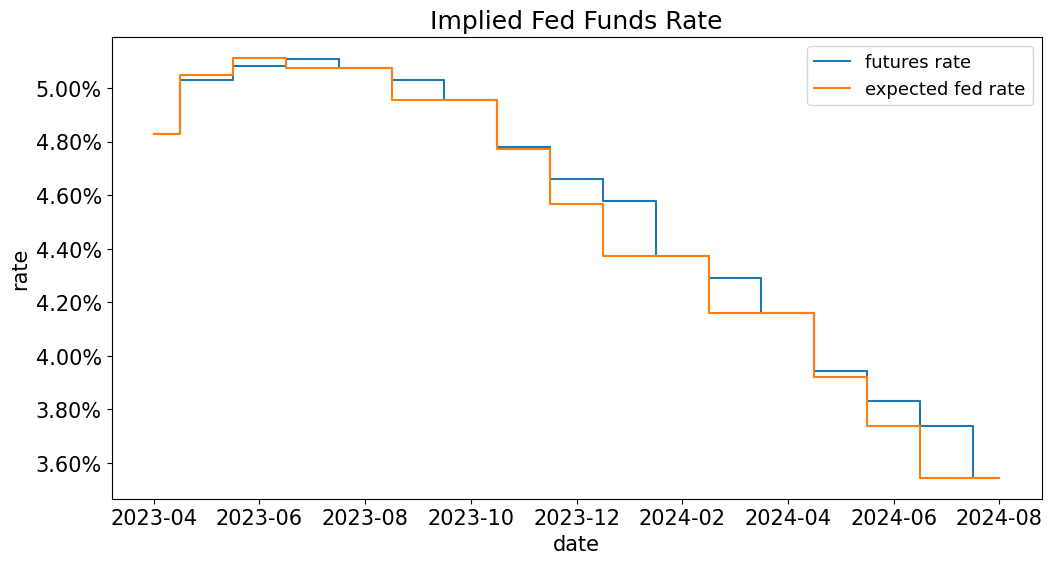

In [27]:
curveplot = curve[['futures rate','expected fed rate']].dropna(subset='expected fed rate')
ax = curveplot.plot(drawstyle='steps-mid');
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=None, symbol='%'));
ax.set_ylabel('rate');
ax.set_title('Implied Fed Funds Rate');

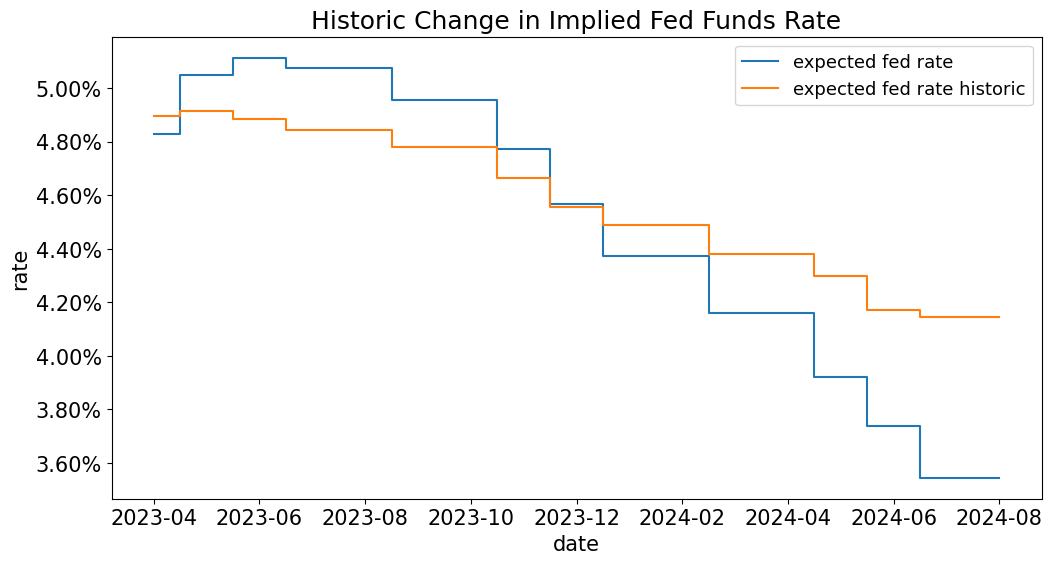

In [28]:
curveplot = curve[['expected fed rate','expected fed rate historic']].dropna(subset='expected fed rate')
ax = curveplot.plot(drawstyle='steps-mid');
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=None, symbol='%'));
ax.set_ylabel('rate');
ax.set_title('Historic Change in Implied Fed Funds Rate');

## Extra: Considering Liquidity

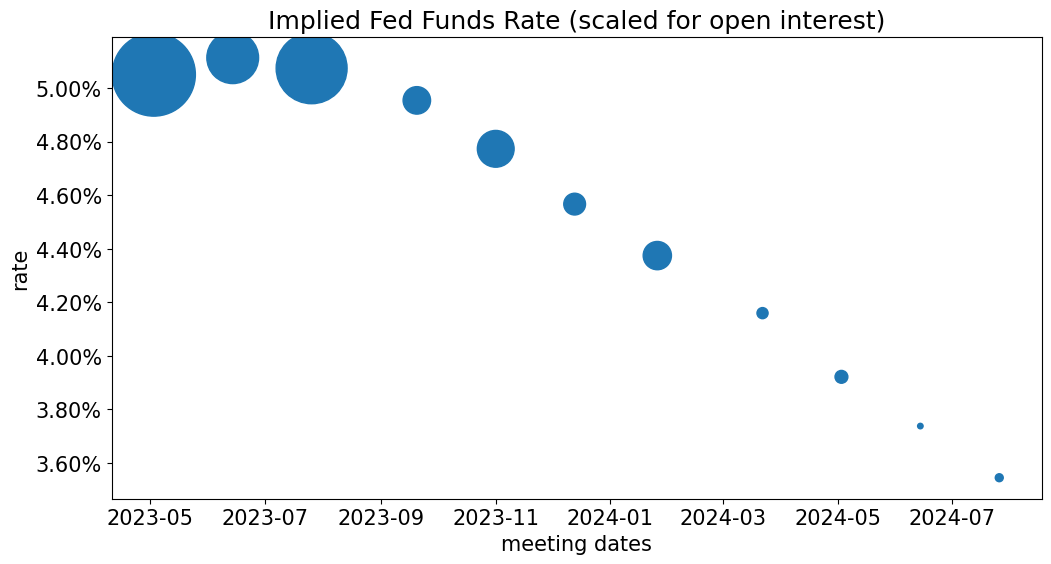

In [29]:
ax = curve.plot.scatter(x='meeting dates', y='expected fed rate', s=fedfut['open_int']/100);
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=None, symbol='%'));
ax.set_ylabel('rate');
ax.set_title('Implied Fed Funds Rate (scaled for open interest)');

## <span style="color:red">2.4 Probabilities</span>

The paths we extract are the market's implied expected fed rates assuming
* rates change only on fed meeting dates

In some sense, one might see this as the risk-neutral expectation of Fed rates.

### Probabilities?

Note that from these futures alone we can only extract the **expected** rate, but nothing about the probability distribution of a given rate.

To estimate probabilities of various Fed decisions, we would need a model for their meeting outcome possibilities, and we might use other data, such as options on STIR futures, to estimate the probability distribution.